In [73]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
import functools

In [59]:
mobility_train = pd.read_csv('train_Wc8LBpr.csv')
mobility_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
Trip_ID                        131662 non-null object
Trip_Distance                  131662 non-null float64
Type_of_Cab                    111452 non-null object
Customer_Since_Months          125742 non-null float64
Life_Style_Index               111469 non-null float64
Confidence_Life_Style_Index    111469 non-null object
Destination_Type               131662 non-null object
Customer_Rating                131662 non-null float64
Cancellation_Last_1Month       131662 non-null int64
Var1                           60632 non-null float64
Var2                           131662 non-null int64
Var3                           131662 non-null int64
Gender                         131662 non-null object
Surge_Pricing_Type             131662 non-null int64
dtypes: float64(5), int64(4), object(5)
memory usage: 14.1+ MB


In [60]:
mobility_train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [61]:
mobility_test = pd.read_csv('test_VsU9xXK.csv')
mobility_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87395 entries, 0 to 87394
Data columns (total 13 columns):
Trip_ID                        87395 non-null object
Trip_Distance                  87395 non-null float64
Type_of_Cab                    74237 non-null object
Customer_Since_Months          83429 non-null float64
Life_Style_Index               74068 non-null float64
Confidence_Life_Style_Index    74068 non-null object
Destination_Type               87395 non-null object
Customer_Rating                87395 non-null float64
Cancellation_Last_1Month       87395 non-null int64
Var1                           40606 non-null float64
Var2                           87395 non-null int64
Var3                           87395 non-null int64
Gender                         87395 non-null object
dtypes: float64(5), int64(3), object(5)
memory usage: 8.7+ MB


In [62]:
mobility_train['Type_of_Cab'].unique()

array(['B', nan, 'C', 'E', 'D', 'A'], dtype=object)

In [63]:
mobility_train['Destination_Type'].unique()

array(['A', 'E', 'B', 'C', 'G', 'D', 'F', 'K', 'L', 'H', 'I', 'J', 'M',
       'N'], dtype=object)

In [64]:
mobility_train['Confidence_Life_Style_Index'].unique()

array(['A', 'B', nan, 'C'], dtype=object)

In [65]:
type_of_cab = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
encode = {'Type_of_Cab': {'A': 0,'B': 1,'C': 2,'D': 3,'E' : 4},
          'Confidence_Life_Style_Index' : {'A': 0,'B': 1,'C': 2},
          'Gender':{'Male': 0,'Female': 1}
         }
          
mobility_train.replace(encode,inplace=True)
mobility_test.replace(encode,inplace=True)

In [66]:
for type in ['Destination_Type']:
    lbl = LabelEncoder()
    lbl.fit(list(mobility_train[type].values) + list(mobility_test[type].values)) 
    mobility_train[type] = lbl.transform(list(mobility_train[type].values))
    mobility_test[type] = lbl.transform(list(mobility_test[type].values))

# mobility_train['Surge_Pricing_Type'] = mobility_train['Surge_Pricing_Type'] - 1

In [67]:
mobility_train['Surge_Pricing_Type'].unique()

array([2, 3, 1], dtype=int64)

In [68]:
mobility_train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1.0,1.0,2.42769,0.0,0,3.90500,0,40.0,46,60,1,2
1,T0005689461,29.47,1.0,10.0,2.78245,1.0,0,3.45000,0,38.0,56,78,0,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,4,3.50125,2,NaN,56,77,0,2
3,T0005689465,61.56,2.0,10.0,NaN,NaN,0,3.45375,0,NaN,52,74,0,3
4,T0005689467,54.95,2.0,10.0,3.03453,1.0,0,3.40250,4,51.0,49,102,0,2


In [69]:
mobility_test.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,0.0,10.0,2.57438,0.0,1,3.68000,2,NaN,46,63,0
1,T0005689462,32.15,1.0,10.0,2.85143,0.0,0,1.59375,0,65.0,49,80,1
2,T0005689463,10.38,2.0,4.0,2.70530,0.0,3,4.50500,0,NaN,47,74,0
3,T0005689466,14.94,NaN,6.0,2.48159,2.0,4,4.53000,0,63.0,43,54,0
4,T0005689468,32.03,1.0,7.0,2.81598,0.0,10,4.60125,3,96.0,44,56,0


In [70]:
# X = mobility_train.iloc[:,1:-1]
# y = mobility_train.iloc[:,-1]

X = mobility_train.iloc[:,1:-1]
y = mobility_train.iloc[:,-1]

X = X.fillna(-999)
y = y.fillna(-999)
X.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,6.77,1.0,1.0,2.42769,0.0,0,3.90500,0,40.0,46,60,1
1,29.47,1.0,10.0,2.78245,1.0,0,3.45000,0,38.0,56,78,0
2,41.58,-999.0,10.0,-999.00000,-999.0,4,3.50125,2,-999.0,56,77,0
3,61.56,2.0,10.0,-999.00000,-999.0,0,3.45375,0,-999.0,52,74,0
4,54.95,2.0,10.0,3.03453,1.0,0,3.40250,4,51.0,49,102,0


In [71]:
def opt(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 200,250)
    max_depth = trial.suggest_int('max_depth', 3,7)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 3)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.08, 0.13, 0.01)
    subsample = trial.suggest_discrete_uniform('subsample', 0.7, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.7, 0.9, 0.1)

    xgboost_tuna = xgb.XGBClassifier(
        random_state=123, 
        objective = 'multi:softmax',
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        n_jobs=-1
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_test)
    
    return (1-(accuracy_score(y_test, tuna_pred_test)))

In [ ]:
study = optuna.create_study()
study.optimize(functools.partial(opt, X_train, y_train, X_eval, y_eval), n_trials=70)

In [80]:
def classification_model_xgb_multi(X, y,SEED=123):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=SEED)
    model = xgb_classifier_multi(X_train,y_train,SEED)
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    print(accuracy_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print(accuracy)
    return model

def xgb_classifier_multi(X_train,y_train,SEED):
    xg_cl = xgb.XGBClassifier(objective = 'multi:softmax',n_estimators =230,booster="gbtree",min_child_weight=3,learning_rate=0.12, max_depth=5, subsample=0.8, colsample_bytree=0.7,tree_method='exact',seed=123)           
    xg_cl.fit(X_train,y_train)
    return xg_cl

In [81]:
model4 = classification_model_xgb_multi(X, y)

0.7241785263317795
0.7063000797478449


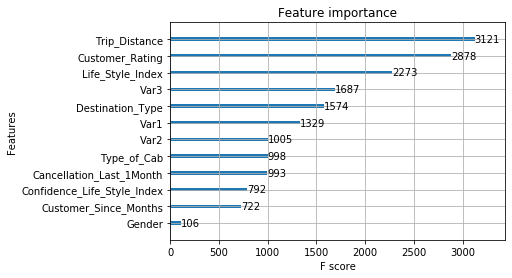

In [96]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(model4)
plt.show()

In [76]:
mobility_test = mobility_test.fillna(-999)
X_val = mobility_test.iloc[:,1:]

In [77]:
X_val.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,9.44,0.0,10.0,2.57438,0.0,1,3.68000,2,-999.0,46,63,0
1,32.15,1.0,10.0,2.85143,0.0,0,1.59375,0,65.0,49,80,1
2,10.38,2.0,4.0,2.70530,0.0,3,4.50500,0,-999.0,47,74,0
3,14.94,-999.0,6.0,2.48159,2.0,4,4.53000,0,63.0,43,54,0
4,32.03,1.0,7.0,2.81598,0.0,10,4.60125,3,96.0,44,56,0


In [82]:
predictions = model4.predict(X_val)

In [83]:
submit = pd.DataFrame({'Trip_ID': mobility_test['Trip_ID'], 'Surge_Pricing_Type': predictions})
submit.to_csv("XGB52.csv", index=False)